## Training a clustering/classifying model based on healthy microstructural data.

In [1]:
import numpy as np 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import nibabel as nib
from skops.io import dump, load
import sklearn.metrics as metrics
import skfuzzy as fuzz
from sklearn.neighbors import KNeighborsClassifier
import time

## First set up base folder where all the data lives
base_folder = "/Users/sharada/Documents/Projects/MDDE/V3/"

/Users/sharada/Documents/Venvs/mri_venv_basic/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


### Load in all the microstructure maps from all the healthy controls. 
### Requires that maps are registered to the same space for each subject (e.g. MWF, uFA and CMD maps are all registered together for each subject), and that for every subject there is a brain mask that excludes CSF. Run processing/initial_processing_hc.sh, see example_processing_usage.sh for usage.

### This is an example of splitting the whole healthy dataset up into a training (75-80% of the data) and testing set and iterating through different cluster numbers to find the "best" one.

In [4]:
## Empty dataframes to hold all subject's data, one dataframe per metric. Can expand as needed.
df_train = pd.DataFrame()
df_train['img_1'] = 0
df_train['img_2'] = 0
df_train['img_3'] = 0

## All the healthy controls we will use. 
subject_list = ["YEG_CONTROL", "LOBSTR_C011", "LOBSTR_C018", "LOBSTR_C019", "LOBSTR_C036", "LOBSTR_C037",
                "REPRO_C01", "REPRO_C02", "REPRO_C03", "REPRO_C04", "REPRO_C05", "REPRO_C07", 
                "LOBSTR_C029", "LOBSTR_C023", "LOBSTR_C009", "LOBSTR_C038", "LOBSTR_C017", "LOBSTR_C025",
                "LOBSTR_C014", "LOBSTR_C028", "LOBSTR_C020", "LOBSTR_C035", "LOBSTR_C006", "LOBSTR_C007",
                "LOBSTR_C012"]   

test_subject_list = ["LOBSTR_C020", "LOBSTR_C035", "LOBSTR_C006", "LOBSTR_C007", "LOBSTR_C012"]

#Load in each training subject's data
for subject in subject_list:
    if subject not in test_subject_list:
        ##Names of folders
        folder_mask = base_folder + subject + "/ants/CALIPR/" ##Folder containing the brain mask that excludes CSF
        folder_metrics_mwf = base_folder + subject + "/ants/CALIPR/" ##Folder containing the MWF map for the subject
        folder_metrics_tvde = base_folder + subject + "/ants/CALIPR_MDD/" ##Folder containing the uFA, CMD maps for the subject (registered to MWF space)
        folder_clustering = base_folder + subject + "/clustering_outputs/" ##Folder where clustering output will go

        ##Load in data
        mask = nib.load(folder_mask+"mask_no_csf.nii.gz").get_fdata()  ##Whole brain excluding CSF
        img_data_1 = nib.load(folder_metrics_tvde+"ufa.nii.gz").get_fdata()  ##uFA map
        img_data_2 = nib.load(folder_metrics_tvde+"cmd.nii.gz").get_fdata()  ##C_MD map
        img_data_3 = nib.load(folder_metrics_mwf+"MWF_brain_ero.nii.gz").get_fdata()  ##MWF map

        ##Wherever the mask is 1, take only that metric data into account. We 
        img_1_nonzero = img_data_1[mask == 1]
        img_2_nonzero = img_data_2[mask == 1]
        img_3_nonzero = img_data_3[mask == 1]

        print("Training: " + subject)

        ##Stick all of these into a dataframe for processing.
        df1 = pd.DataFrame() ##Temporary holder
        df1['img_1'] = img_1_nonzero
        df1['img_2'] = img_2_nonzero
        df1['img_3'] = img_3_nonzero
        df_train = pd.concat([df_train, df1]) ##Concatenate into main container

Training: YEG_CONTROL
Training: LOBSTR_C011
Training: LOBSTR_C018
Training: LOBSTR_C019
Training: LOBSTR_C036
Training: LOBSTR_C037
Training: REPRO_C01
Training: REPRO_C02
Training: REPRO_C03
Training: REPRO_C04
Training: REPRO_C05
Training: REPRO_C07
Training: LOBSTR_C029
Training: LOBSTR_C023
Training: LOBSTR_C009
Training: LOBSTR_C038
Training: LOBSTR_C017
Training: LOBSTR_C025
Training: LOBSTR_C014
Training: LOBSTR_C028


### Next we scale the big training dataset (centred around 0, normal distribution with unit stdev) and cluster with a range of cluster numbers (k-values). For each, we make and save a classifier model that can be applied to other datasets.

In [4]:
##Scale the data (to be normalized). Important since the different microstructural measures will have different dynamic ranges.
scaler = StandardScaler().fit(df_train)
scaled_data = scaler.transform(df_train)
print(scaled_data.shape)

##Build and save models that you can apply later to test other datasets.
start_time = time.time()

##This is the number of clusters, can iterate through multiple and check Calinski-Harabasz, Davies-Bouldin, Dunn, Silhouette etc scores to judge their goodness.
k_vals = [2, 3, 4, 5, 6, 7, 8, 9]
knns_stored = []

##Loop for running through multiple k values (if needed)
for i in k_vals:
    ##Fuzzy C-Means clustering of the scaled data
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        scaled_data.T, i, 2, error=0.005, maxiter=100, init=None)
    
    ##Take the highest membership probability for each datapoint
    labeled_0 = np.argmax(u, axis=0) 

    ##Classify the data based on labels generated from clustering. This will be our model.
    knn = KNeighborsClassifier(n_neighbors=9, weights='uniform').fit(scaled_data, labeled_0)
    
    ##Save this model (the classifier) using skops.io, can later re-load it whenever necessary and classify other new data.
    ##This will save us having to re-classify every single time and hold it in memory.
    dump(knn, "model_{}clusters.skops".format(i))
    print("{} Clusters Done".format(i))

print(time.time() - start_time)

2 Clusters Done
3 Clusters Done
4 Clusters Done
5 Clusters Done
6 Clusters Done
7 Clusters Done
8 Clusters Done
9 Clusters Done
3484.5423259735107


### If you iterated through several k-values and want to test their "goodness", see below.

### Here we take 5 test subjects (ideally not part of the training set!!!), apply each of the classifier models in turn to each test dataset and calculate scores to determine goodness of clustering.

In [6]:
##A set of test subjects (ideally they are not part of the training set)
test_subject_list = ["LOBSTR_C020", "LOBSTR_C035", "LOBSTR_C006", "LOBSTR_C007", "LOBSTR_C012"]

##A list of trained models if you looped through several
trained_models = ['model_2clusters.skops', 'model_3clusters.skops', 'model_4clusters.skops', 'model_5clusters.skops', 'model_6clusters.skops', 'model_7clusters.skops', 'model_8clusters.skops', 'model_9clusters.skops']
cluster_numbers = [2, 3, 4, 5, 6, 7, 8, 9] ##Keep track of how many clusters each model does.

##Iterate through subjects
for subject in test_subject_list:

    ##Set up folders
    folder_mask = base_folder + subject + "/ants/CALIPR/" ##Location of whole-brain mask excluding CSF
    folder_metrics_mwf = base_folder + subject + "/ants/CALIPR/" ##Location of MWF map
    folder_metrics_tvde = base_folder + subject + "/ants/CALIPR_MDD/" ##Location of uFA and CMD maps registered to MWF space
    folder_clustering = base_folder + subject + "/clustering_outputs_test/" ##Location of clustering outputs for testing
    !mkdir {folder_clustering}

    img_mask = nib.load(folder_mask+"mask_no_csf.nii.gz")
    mask = nib.load(folder_mask+"mask_no_csf.nii.gz").get_fdata()  #Whole-brain mask excluding CSF
    img_data_1 = nib.load(folder_metrics_tvde+"ufa.nii.gz").get_fdata()  #uFA 
    img_data_2 = nib.load(folder_metrics_tvde+"cmd.nii.gz").get_fdata()  #C_MD
    img_data_3 = nib.load(folder_metrics_mwf+"MWF_brain_ero.nii.gz").get_fdata()  #MWF

    ##Wherever the mask is 1, take only that metric data into account.
    img_1_nonzero = img_data_1[mask == 1]
    img_2_nonzero = img_data_2[mask == 1]
    img_3_nonzero = img_data_3[mask == 1]

    print("Testing: " + subject)

    ##Stick all of these into a dataframe for processing.
    df_test = pd.DataFrame() #Make it fresh each time!
    df_test['img_1'] = img_1_nonzero
    df_test['img_2'] = img_2_nonzero
    df_test['img_3'] = img_3_nonzero

    ##Scale the test dataset as we did with the training set
    scaler_test = StandardScaler().fit(df_test)
    scaled_data_test = scaler_test.transform(df_test)

    ###Calculate and store metrics
    columns = ['K', 'CH_score', 'DB_score']
    df_scores = pd.DataFrame(columns=columns, index=np.arange(len(trained_models)))
    i = 0

    ##Load in the pre-trained model one by one and run on the data
    for model in trained_models:
        loaded_knn = load(model, trusted=True) ##Load in the saved classifier

        ##Run the classifier on our data
        labeled_test = loaded_knn.predict(scaled_data_test)

        #Now transform the labels back into the shape of a NIFTI and convert it to a NIFTI.
        reshaped_labels = mask.copy()
        reshaped_labels[mask==1] = labeled_test + 1 #Adding the +1 because labels are 0,1,2... and it gets confusing to look at a 0 region on FSL!
        new_header = img_mask.header.copy()
        ni_img = nib.Nifti1Image(reshaped_labels, None, header=new_header)
        nib.save(ni_img, folder_clustering+"new_labels_fuzzc_knn{}.nii.gz".format(cluster_numbers[i])) ##Save as NIFTI

        ##Calculate Calinski-Harabasz and Davies-Bouldin scores and store it for each subject, for each classifier model.
        df_scores.loc[i,'K'] = cluster_numbers[i]
        df_scores.loc[i,'CH_score'] = metrics.calinski_harabasz_score(scaled_data_test, labeled_test)
        df_scores.loc[i,'DB_score'] = metrics.davies_bouldin_score(scaled_data_test, labeled_test)
        i = i + 1

    print(df_scores)
    df_scores.to_csv(folder_clustering+'test_scores.csv', index=False) ##Save scores from all subjects into one CSV.
    

Testing: LOBSTR_P072
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=9)
   K       CH_score  DB_score
0  2  690080.515937  1.021634
1  3  537013.935323    1.2316
2  4  499495.153838  1.121467
3  5  440995.912546  1.203158
4  6  416176.538904  1.146111
5  7  382962.308621  1.258915
6  8  371944.946611  1.173466
7  9  349317.955308  1.247983
Testing: LOBSTR_P085
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=9)
   K       CH_score  DB_score
0  2  515948.009173  1.220088
1  3  445214.967342  1.351397
2  4  429348.212579  1

### Once you have Calinski-Harabasz and Davies-Bouldin scores for everyone, plot them out. 
### With C-H we look for higher scores (lower between-cluster dispersion), for D-B we look for lower scores (lower within-cluster distance). A good combination of both is a good cluster... but also need to check if it visibly makes sense!
### C-H and D-B are not the only scores that exist!

Text(0, 0.5, 'Davies-Bouldin scores')

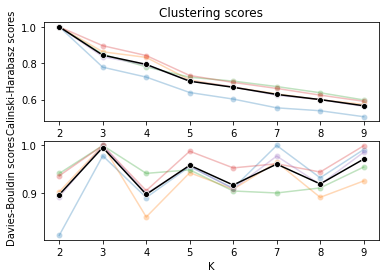

In [7]:
##Make plots of CH, DB scores 
test_subject_list = ["YEG_CONTROL", "LOBSTR_C011", "LOBSTR_C018", "LOBSTR_C019", "LOBSTR_C036"]
total_scores = pd.DataFrame()

##Load in everyone's test scores into one big dataframe that we can then plot out
for subject in test_subject_list:
    folder_clustering = base_folder + subject + "/clustering_outputs_test/"
    data = pd.read_csv(folder_clustering+'test_scores.csv')
    data.dropna(inplace=True)
    subjectname = np.repeat(subject, len(data))

    total_scores_temp = pd.DataFrame()
    total_scores_temp['K'] = data['K']
    total_scores_temp['CH_score'] = data['CH_score']/(data['CH_score'].max())
    total_scores_temp['DB_score'] = data['DB_score']/(data['DB_score'].max())
    total_scores_temp['Subject'] = subjectname
    total_scores = pd.concat([total_scores, total_scores_temp])

#print(total_scores)

##Make separate holders for average CH and DB scores to plot along with the everyone-included scores
cols = ['K', 'CH_score']
avg_ch_score = pd.DataFrame(columns=cols, index=[2,3,4,5,6,7,8,9])
for i in range(2, len(data)+2):
    avg_ch_score.loc[i, 'K'] = i
    avg_ch_score.loc[i, 'CH_score'] = total_scores[total_scores['K']==i]['CH_score'].mean()


cols = ['K', 'DB_score']
avg_db_score = pd.DataFrame(columns=cols, index=[2,3,4,5,6,7,8,9])
for i in range(2, len(data)+2):
    avg_db_score.loc[i, 'K'] = i
    avg_db_score.loc[i, 'DB_score'] = total_scores[total_scores['K']==i]['DB_score'].mean()

fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

g = sns.lineplot(ax=ax1, data=total_scores, x='K', y='CH_score', hue='Subject', legend=False, marker='o', alpha=0.3)
sns.lineplot(ax=ax1, data=avg_ch_score, x='K', y='CH_score',legend=False, marker='o', color='black')
sns.lineplot(ax=ax2, data=total_scores, x='K', y='DB_score', hue='Subject', legend=False, marker='o', alpha=0.3)
sns.lineplot(ax=ax2, data=avg_db_score, x='K', y='DB_score', legend=False, marker='o', color='black')
g.set_title('Clustering scores')
ax1.set_ylabel('Calinski-Harabasz scores')
ax2.set_ylabel('Davies-Bouldin scores')

### You can iterate through the testing/training subjects and look at these scores and also evaluate the resulting tissue classification maps. Once you're happy with the cluster number, repeat the steps above with ALL the data (and no "test set"), and save a model with the best number of clusters. This classifier can then be used on the metric atlases and all MS subjects.